In [2]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
import pandas as pd
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

In [10]:
train = train.drop(['casual', 'registered'], axis=1)

In [11]:
print(train.shape)
print(test.shape)

(10886, 10)
(6493, 9)


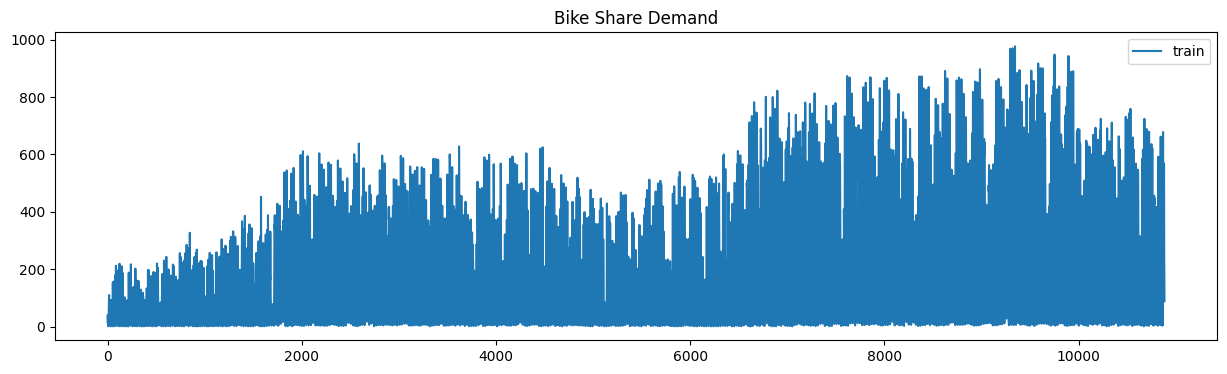

In [13]:
train['count'].plot(figsize=(15,4), legend=True)
plt.legend(['train'])
plt.title('Bike Share Demand')
plt.show()

In [ ]:
#pacf 이용하여 차수 추정
from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=9, method='ols', title='pa').show

In [ ]:
#전처리 작업 - 데이터의 스케일작업 (MinMaxscale)

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [ ]:
train_scaled

In [ ]:
train_scaled.shape

In [ ]:
#시계열 딥러닝은 자기 자신의 과거를 독립변수로 활용한다. 1시간 단위로 시프트 시키는 작업을 해본다.

In [ ]:
x_train = []
y_train = []

for i in range(1, 17000):
    x_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train.shape

In [ ]:
#시계열 딥러닝은 3차원 배열을 필요로 한다. 3차원 배열로 전처리

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import SimpleRNN

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

In [ ]:
print(rnn.summary())

In [ ]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [ ]:
rnn.fit(x_train, y_train, batch_size=1, epochs=2)

In [ ]:
inputs = sc.transform(test)
inputs.shape

In [ ]:
x_test = []
for i in range(1, 415):
    x_test.append(inputs[i-1:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

In [ ]:
rnn = rnn.predict(x_test)
rnn = sc.inverse_transform(rnn)

In [ ]:
test1 = pd.DataFrame(test)
rnn1= pd.DataFrame(rnn)

In [ ]:
test1.plot(figsize=(15,4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

In [ ]:
rnn1.plot(figsize=(15,4), legend=True)
plt.legend(['RNN'])
plt.title('bike share demand')
plt.show()

In [ ]:
test = np.array(test)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.legend()

In [ ]:
from keras.layers import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [ ]:
print(lstm.summary())

In [ ]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(x_train, y_train, batch_size=1, epochs=2)

In [ ]:
lstm = lstm.predict(x_test)
lstm = sc.inverse_transform(lstm)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker=',', label='RNN', color='green')
plt.legend()

In [ ]:
from keras.layers import GRU

gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [ ]:
print(gru.summary())

In [ ]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(x_train, y_train, batch_size=1, epochs=2)

In [ ]:
gru = gru.predict(x_test)
gru = sc.inverse_transform(gru)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.plot(lstm, marker=',', label='LSTM', color='green')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [ ]:
print('RNN RMSE:', RMSE(test, rnn))

In [ ]:
print('LSTM RMSE:', RMSE(test, lstm))

In [ ]:
print('GRU RMSE:', RMSE(test, gru))